[View in Colaboratory](https://colab.research.google.com/github/TonyIssacJames/EIP_public/blob/master/DNST_CIFAR10_AUG.ipynb)

In [1]:
# https://keras.io/
#!pip install -q keras
import keras

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam

In [3]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [14]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 50
l = 15
num_filter = 24
compression = 0.7
dropout_rate = 0.20

In [15]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [16]:
import numpy as np

x_train = np.append(x_train, x_train,axis=0)
y_train = np.append(y_train, y_train,axis=0)
print(x_train.shape)
#print(np.append(x_train, x_train,axis=0).shape)
#print(np.append(y_train, y_train,axis=0).shape)
print(y_train.shape)

(100000, 32, 32, 3)
(100000, 10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  if __name__ == '__main__':


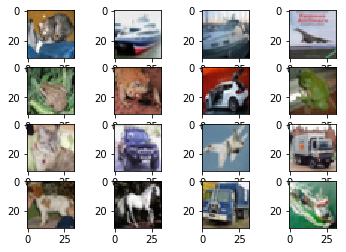

In [17]:
from matplotlib import pyplot
from scipy.misc import toimage
def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            pyplot.subplot2grid((4,4),(i,j))
            pyplot.imshow(toimage(X[k]))
            k = k+1
    # show the plot
    pyplot.show()

show_imgs(x_test[:16])

In [18]:
print(y_test[:16])

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [19]:
#Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,    # randomly flip images
        fill_mode='nearest')

In [20]:
#Callback for saving the best model
from keras.callbacks import ModelCheckpoint
filepath= "weights_tr_05_v2.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [21]:
# Dense Block
def add_denseblock(input, num_filter = 24, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [22]:
def add_transition(input, num_filter = 24, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [23]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

In [24]:
#num_filter = 16
#Sdropout_rate = 0.2
#l = 12
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Fourth_Block = add_denseblock(Third_Transition, num_filter, dropout_rate)
Fourth_Transition = add_transition(Fourth_Block, num_filter, dropout_rate)

#Fifth_Block = add_denseblock(Fourth_Transition, num_filter, dropout_rate)
#Fifth_Transition = add_transition(Fifth_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Fourth_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)


In [25]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 24)   648         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 24)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 24)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [26]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
#Save the data so reloading will be easy
np.save("x_train", x_train)
np.save("y_train", y_train)
np.save("x_test", x_test)
np.save("y_test", y_test)


In [27]:
'''model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)'''

model.fit_generator(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=5,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)

Epoch 1/5
782/782 [==============================] - 764s 977ms/step - loss: 1.6354 - acc: 0.3932 - val_loss: 1.9286 - val_acc: 0.4274

Epoch 00001: val_acc improved from -inf to 0.42740, saving model to weights_tr_05_v2.best.hdf5
Epoch 2/5
782/782 [==============================] - 671s 858ms/step - loss: 1.2677 - acc: 0.5436 - val_loss: 2.4901 - val_acc: 0.4513

Epoch 00002: val_acc improved from 0.42740 to 0.45130, saving model to weights_tr_05_v2.best.hdf5
Epoch 3/5
782/782 [==============================] - 671s 858ms/step - loss: 0.9840 - acc: 0.6521 - val_loss: 1.0411 - val_acc: 0.6595

Epoch 00004: val_acc improved from 0.56930 to 0.65950, saving model to weights_tr_05_v2.best.hdf5
Epoch 5/5
782/782 [==============================] - 670s 856ms/step - loss: 0.9076 - acc: 0.6830 - val_loss: 1.7530 - val_acc: 0.5659

Epoch 00005: val_acc did not improve from 0.65950


In [28]:
model.save('weights_tr_05_v2_epoch_2.hdf5')  # creates a HDF5 file 'my_model.h5'

In [29]:
#Save the data so reloading will be easy
np.save("x_train", x_train)
np.save("y_train", y_train)
np.save("x_test", x_test)
np.save("y_test", y_test)

In [30]:
'''model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)'''

model.fit_generator(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=5,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)

Epoch 1/5
782/782 [==============================] - 668s 854ms/step - loss: 0.8411 - acc: 0.7075 - val_loss: 0.9860 - val_acc: 0.7146

Epoch 00001: val_acc improved from 0.65950 to 0.71460, saving model to weights_tr_05_v2.best.hdf5
Epoch 2/5
782/782 [==============================] - 671s 858ms/step - loss: 0.7908 - acc: 0.7256 - val_loss: 1.5897 - val_acc: 0.5887

Epoch 00002: val_acc did not improve from 0.71460
Epoch 3/5
782/782 [==============================] - 672s 859ms/step - loss: 0.7488 - acc: 0.7417 - val_loss: 1.0648 - val_acc: 0.6928

Epoch 00003: val_acc did not improve from 0.71460
Epoch 4/5
782/782 [==============================] - 668s 855ms/step - loss: 0.7123 - acc: 0.7544 - val_loss: 0.9650 - val_acc: 0.7041

Epoch 00004: val_acc did not improve from 0.71460
Epoch 5/5
782/782 [==============================] - 667s 853ms/step - loss: 0.6820 - acc: 0.7659 - val_loss: 0.7442 - val_acc: 0.7739

Epoch 00005: val_acc improved from 0.71460 to 0.77390, saving model to w

In [31]:
model.save('weights_tr_05_v2_epoch_10.hdf5')  # creates a HDF5 file 'my_model.h5'

In [32]:
#Save the data so reloading will be easy
np.save("x_train", x_train)
np.save("y_train", y_train)
np.save("x_test", x_test)
np.save("y_test", y_test)

In [33]:
'''model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)'''

model.fit_generator(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=5,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)

Epoch 1/5
782/782 [==============================] - 672s 859ms/step - loss: 0.6521 - acc: 0.7763 - val_loss: 0.8179 - val_acc: 0.7610

Epoch 00001: val_acc did not improve from 0.77390
Epoch 2/5
782/782 [==============================] - 671s 859ms/step - loss: 0.6295 - acc: 0.7833 - val_loss: 0.8100 - val_acc: 0.7533

Epoch 00002: val_acc did not improve from 0.77390
Epoch 3/5
782/782 [==============================] - 672s 859ms/step - loss: 0.6029 - acc: 0.7932 - val_loss: 0.8990 - val_acc: 0.7452

Epoch 00003: val_acc did not improve from 0.77390
Epoch 4/5
782/782 [==============================] - 672s 859ms/step - loss: 0.5842 - acc: 0.7987 - val_loss: 0.8529 - val_acc: 0.7665

Epoch 00004: val_acc did not improve from 0.77390
Epoch 5/5
782/782 [==============================] - 671s 858ms/step - loss: 0.5647 - acc: 0.8047 - val_loss: 0.7705 - val_acc: 0.7722

Epoch 00005: val_acc did not improve from 0.77390


In [35]:
model.save('weights_tr_05_v2_epoch_15.hdf5')  # creates a HDF5 file 'my_model.h5'

In [36]:
'''model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)'''

model.fit_generator(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=5,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)

Epoch 1/5
782/782 [==============================] - 671s 858ms/step - loss: 0.5484 - acc: 0.8109 - val_loss: 0.7213 - val_acc: 0.7942

Epoch 00001: val_acc improved from 0.77390 to 0.79420, saving model to weights_tr_05_v2.best.hdf5
Epoch 2/5
782/782 [==============================] - 671s 858ms/step - loss: 0.5333 - acc: 0.8172 - val_loss: 0.6789 - val_acc: 0.8038

Epoch 00002: val_acc improved from 0.79420 to 0.80380, saving model to weights_tr_05_v2.best.hdf5
Epoch 3/5
782/782 [==============================] - 671s 858ms/step - loss: 0.5172 - acc: 0.8214 - val_loss: 0.7315 - val_acc: 0.7902

Epoch 00003: val_acc did not improve from 0.80380
Epoch 4/5
782/782 [==============================] - 846s 1s/step - loss: 0.5077 - acc: 0.8251 - val_loss: 0.7059 - val_acc: 0.7973

Epoch 00004: val_acc did not improve from 0.80380
Epoch 5/5
782/782 [==============================] - 1217s 2s/step - loss: 0.4963 - acc: 0.8289 - val_loss: 0.7094 - val_acc: 0.8016

Epoch 00005: val_acc did not 

In [37]:
model.save('weights_tr_05_v2_epoch_20.hdf5')  # creates a HDF5 file 'my_model.h5'

In [19]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 18s 2ms/step
Test loss: 0.5077479893147946
Test accuracy: 0.8528


In [38]:
'''model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)'''

model.fit_generator(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=5,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)

Epoch 1/5
782/782 [==============================] - 1234s 2s/step - loss: 0.4872 - acc: 0.8324 - val_loss: 0.7691 - val_acc: 0.7863

Epoch 00001: val_acc did not improve from 0.80380
Epoch 2/5
782/782 [==============================] - 1235s 2s/step - loss: 0.4744 - acc: 0.8374 - val_loss: 0.8123 - val_acc: 0.7831

Epoch 00002: val_acc did not improve from 0.80380
Epoch 3/5
782/782 [==============================] - 1237s 2s/step - loss: 0.4653 - acc: 0.8391 - val_loss: 0.6871 - val_acc: 0.8062

Epoch 00003: val_acc improved from 0.80380 to 0.80620, saving model to weights_tr_05_v2.best.hdf5
Epoch 4/5
782/782 [==============================] - 1235s 2s/step - loss: 0.4590 - acc: 0.8421 - val_loss: 0.8698 - val_acc: 0.7767

Epoch 00004: val_acc did not improve from 0.80620
Epoch 5/5
782/782 [==============================] - 1236s 2s/step - loss: 0.4491 - acc: 0.8462 - val_loss: 0.7899 - val_acc: 0.7944

Epoch 00005: val_acc did not improve from 0.80620


In [39]:
model.save('weights_tr_05_v2_epoch_25.hdf5')  # creates a HDF5 file 'my_model.h5'

In [43]:
#Callback for Cyclic LR
from clr_callback import *
clr = CyclicLR(base_lr=0.0001, max_lr=0.006, step_size=2000., mode='triangular2')
callbacks_list = [checkpoint, clr]

In [44]:
from keras.models import load_model

new_model = load_model('weights_tr_05_v2_epoch_25.hdf5')
score = new_model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 62s 6ms/step
Test loss: 0.7898893290519714
Test accuracy: 0.7944


In [45]:
'''model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)'''

new_model.fit_generator(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=5,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)

Epoch 1/5
782/782 [==============================] - 1247s 2s/step - loss: 0.4639 - acc: 0.8397 - val_loss: 0.8925 - val_acc: 0.7491

Epoch 00001: val_acc did not improve from 0.80620
Epoch 2/5
 62/782 [=>............................] - ETA: 10:10 - loss: 0.5521 - acc: 0.8100

KeyboardInterrupt: 

In [20]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model_tr_05_v2.h5")
print("Saved model to disk")

Saved model to disk


In [22]:
from keras.models import load_model

new_model = load_model("weights_tr_05_v2.best.hdf5")
score = new_model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 22s 2ms/step
Test loss: 0.41088400869369507
Test accuracy: 0.872


In [0]:
#from google.colab import files

#files.download('DNST_model.h5')